# Mt Wilson Sunspot database 1917-1985

From the readme: 

> Sunspot umbral position and area information were digitized from the Mount Wilson daily white-light solar images some years ago (Howard, Gilman, and Gilman, 1984). These photographic images exist in a series that extends from 1917 through the present time. The digitized data extend from 1917 through 1985. Details about the observations, the measurement procedure, and the analysis techniques used earlier may be obtained from the earlier reference (Howard, Gilman, and Gilman, 1984).

These data were first published in [Howard, Gilman, and Gilman, 1984](http://adsabs.harvard.edu/abs/1984ApJ...283..373H). The data are accessible online [here](http://www.ngdc.noaa.gov/stp/solar/sunspotregionsdata.html).

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

paths = glob('/Users/bmmorris/data/Mt_Wilson_Tilt/*/sspot??.dat')

from astropy.time import Time
import astropy.units as u
import string
from astropy.table import Table

In [56]:
def split_interval(string, n, cast_to_type=float):
    return [cast_to_type(string[i:i+n]) for i in range(0, len(string), n)]

all_years_array = []

header = ("jd n_spots_leading n_spots_following n_spots_day_1 n_spots_day_2 "
          "rotation_rate latitude_drift area_weighted_latitude_day_1 area_weighted_longitude_day_1 "
          "area_weighted_longitude_day_2 area_day_1 area_day_2 tilt_day_1 delta_polarity_separation "
          "area_weighted_longitude_day_1_leading area_weighted_longitude_day_1_following "
          "area_weighted_latitude_day_1_leading area_weighted_latitude_day_1_following "
          "area_leading area_following area_weighted_longitude_day_2_leading " 
          "area_weighted_longitude_day_2_following delta_tilt").split()

header = ("jd n_spots_leading n_spots_following n_spots_day_1 n_spots_day_2 "
          "rotation_rate latitude_drift latitude_day_1 latitude_day_2 longitude_day_1 "
          "longitude_day_2 area_day_1 area_day_2 group_latitude_day_1 group_longitude_day_1 "
          "group_area_day_1 group_area_day_2 polarity_day_1 polarity_change tilt_day_1 tilt_day_2 "
          "group_rotation_rate group_latitude_drift").split()

for path in paths:
    f = open(path).read().splitlines()

    n_rows = len(f) // 3
    n_columns = 23#18
    yearly_array = np.zeros((n_rows, n_columns))

    for i in range(n_rows):
        # First five ints specify time, afterwards specify sunspot data
        int_list = split_interval(f[0+i*3][:18], 2, int)
        month, day, year_minus_1900, hour, minute = int_list[:5]
        year = year_minus_1900 + 1900
        jd = Time("{year:d}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}"
                  .format(**locals())).jd
        row = [jd] + int_list[5:] + split_interval(f[1+i*3], 7) + split_interval(f[2+i*3][1:], 7)
        yearly_array[i, :] = row

    all_years_array.append(yearly_array)

table = Table(np.vstack(all_years_array), names=header)

In [57]:
table

jd,n_spots_leading,n_spots_following,n_spots_day_1,n_spots_day_2,rotation_rate,latitude_drift,latitude_day_1,latitude_day_2,longitude_day_1,longitude_day_2,area_day_1,area_day_2,group_latitude_day_1,group_longitude_day_1,group_area_day_1,group_area_day_2,polarity_day_1,polarity_change,tilt_day_1,tilt_day_2,group_rotation_rate,group_latitude_drift
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2421232.78125,1.0,1.0,2.0,3.0,13.254,0.462,13.076,13.515,-11.392,0.269,16.837,12.869,13.142,-11.249,19.615,13.818,1.088,-0.372,-25.35,-28.093,13.151,0.42
2421232.78125,1.0,1.0,2.0,3.0,12.91,0.318,13.542,13.844,-10.382,0.952,2.778,0.899,13.142,-11.249,19.615,13.818,1.088,-0.372,-25.35,-28.093,13.151,0.42
2421232.78125,1.0,1.0,2.0,2.0,12.719,0.056,13.229,13.283,-4.209,6.944,8.4,0.366,13.207,-4.112,9.468,20.938,0.858,0.11,13.468,-22.565,13.568,0.46
2421232.78125,1.0,1.0,2.0,2.0,11.816,0.267,13.029,13.283,-3.352,6.944,1.068,0.366,13.207,-4.112,9.468,20.938,0.858,0.11,13.468,-22.565,13.568,0.46
2421232.78125,1.0,3.0,4.0,12.0,12.936,0.952,13.782,14.687,15.966,27.325,4.734,11.623,13.705,18.61,46.216,58.587,1.884,0.829,-2.183,-2.981,12.176,1.18
2421232.78125,1.0,3.0,4.0,12.0,12.848,1.189,14.035,15.164,16.477,27.753,2.509,3.727,13.705,18.61,46.216,58.587,1.884,0.829,-2.183,-2.981,12.176,1.18
2421232.78125,1.0,3.0,4.0,12.0,12.404,1.368,13.584,14.883,18.342,29.196,16.746,16.449,13.705,18.61,46.216,58.587,1.884,0.829,-2.183,-2.981,12.176,1.18
2421232.78125,1.0,3.0,4.0,12.0,12.795,1.232,13.742,14.913,19.616,30.841,22.228,25.272,13.705,18.61,46.216,58.587,1.884,0.829,-2.183,-2.981,12.176,1.18
2421233.83056,2.0,1.0,3.0,2.0,13.868,0.651,13.844,14.516,0.952,14.261,0.899,2.331,13.538,0.314,13.818,9.298,0.716,0.147,-28.093,-15.763,13.864,0.78


[<matplotlib.text.Text at 0x109295828>, <matplotlib.text.Text at 0x1092aedd8>]

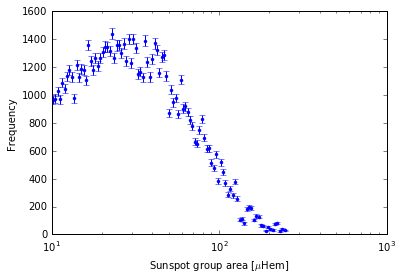

In [92]:
alledges = np.logspace(np.log10(10), np.log10(250), 100)
bin_centers = 0.5*(alledges[:-1] + alledges[1:])
n_spots_per_area_bin = np.zeros_like(bin_centers)
n_spots_per_area_bin_err = np.zeros_like(bin_centers)

for i in range(len(bin_centers)):
    within_bin = ((alledges[i] < table['group_area_day_1']) & 
                  (alledges[i+1] > table['group_area_day_1']))
    n_spots_per_area_bin[i] = np.count_nonzero(within_bin)
    n_spots_per_area_bin_err[i] = np.sqrt(n_spots_per_area_bin[i])
    
fig, ax = plt.subplots()
# ax.set_yscale("log")#, nonposy='clip')
ax.set_xscale("log")
ax.errorbar(bin_centers, n_spots_per_area_bin, 
            n_spots_per_area_bin_err, fmt='.')
ax.set(xlabel="Sunspot group area [$\mu$Hem]", 
       ylabel="Frequency")


[  1.42062603e+03   3.22503784e+00   8.48172930e-01] 1


[<matplotlib.text.Text at 0x111fa82e8>, <matplotlib.text.Text at 0x111f734e0>]

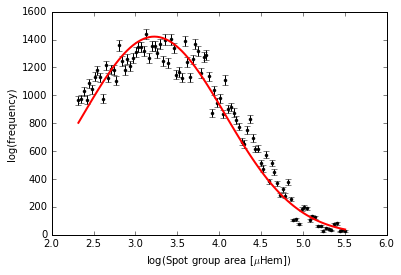

In [93]:
from scipy.optimize import leastsq

def fit_model(p, x):
    a, x0, sigma = p
    return a * np.exp(-0.5 * (x - x0)**2 / sigma**2)

log_bins = np.log(bin_centers)

def chi2(p, x):
    return (fit_model(p, x) - n_spots_per_area_bin) / n_spots_per_area_bin_err

initp = [2000, 3.2, 1.0]
bestp, success = leastsq(chi2, initp, args=(log_bins,))

fig, ax = plt.subplots()
ax.errorbar(log_bins, n_spots_per_area_bin, n_spots_per_area_bin_err, fmt='k.')
ax.plot(log_bins, fit_model(bestp, log_bins), color='r', lw=2)
ax.set(xlabel="log(Spot group area [$\mu$Hem])", ylabel="log(frequency)")

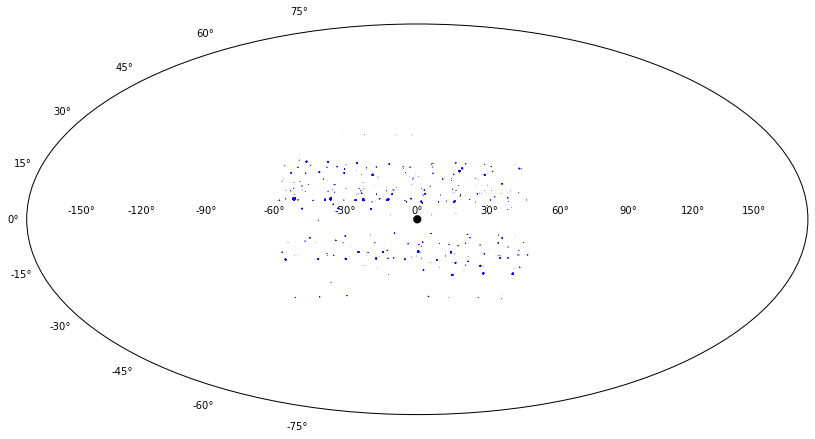

In [120]:
start_time = Time('1969-01-01')
end_time = Time('1969-06-01')

time_range = (table['jd'] < end_time.jd) & (table['jd'] > start_time.jd)
spots_within_range = table[time_range]


projection = 'Hammer'

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(111, projection=projection.lower())#, axisbg='black')

from astroML.plotting import plot_tissot_ellipse
#rp_rs = 0.058330305324663184
#radius = 1.0*np.tan(rp_rs)  # from s=r*theta

cmap = plt.cm.viridis
for spot in spots_within_range: 
    latitude, longitude = spot['group_latitude_day_1'], spot['group_longitude_day_1']
    area = 1e-6*spot['group_area_day_1']
    
    radius = np.tan(np.sqrt(2 * area))
    
    p = plot_tissot_ellipse(np.radians(longitude), np.radians(latitude), 
                            radius, ax=ax, linewidth=0,
                            alpha = 1)
    
p = plot_tissot_ellipse(0, 0, 
                        np.tan(rp_rs), ax=ax, linewidth=0,
                        alpha = 1, color='k')

[<matplotlib.text.Text at 0x11c9aff98>, <matplotlib.text.Text at 0x11c981c88>]

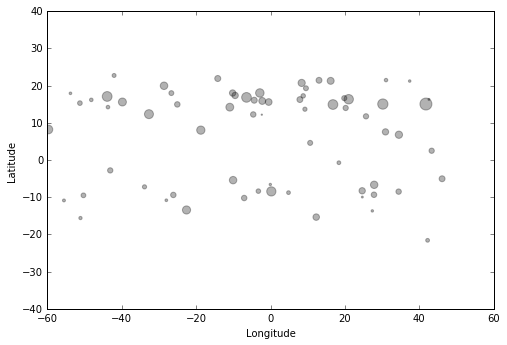

In [148]:
from matplotlib.patches import Ellipse
start_time = Time('1970-01-01')
end_time = Time('1971-01-01')

time_range = (table['jd'] < end_time.jd) & (table['jd'] > start_time.jd)
spots_within_range = table[time_range][::50]

# Plot the built-in projections
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)

cmap = plt.cm.viridis
for spot in spots_within_range: 
    latitude, longitude = spot['group_latitude_day_1'], spot['group_longitude_day_1']
    area = 1e-6*spot['group_area_day_1']
    
    radius = 90 * np.tan(np.sqrt(2 * area))
    
    #print(longitude, latitude, radius)
    circle1=plt.Circle((longitude, latitude), radius, color='k', alpha=0.3)
    ax.add_artist(circle1)
    
ax.set_xlim([-60, 60])
ax.set_ylim([-40, 40])
ax.set_aspect(1)
ax.set(xlabel='Longitude', ylabel='Latitude')